Accompanying notebook for the talk *Designing **with** data* by <a href="https://www.linkedin.com/in/joshuanewnham">Joshua Newnham</a> - 2017

# Model creation and training

TODO add intro 

In [1]:
import constants as constants

import pickle 
import numpy as np 
import os
import time 
import random 
from random import randint

from keras.layers import Input, Embedding, Activation, LSTM, TimeDistributed
from keras.layers import Dense, RepeatVector, Dropout, concatenate
from keras.optimizers import Adam 
from keras.models import Model, Sequential
from keras.preprocessing import sequence

import h5py

import keras.backend as K

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
%matplotlib inline
plt.style.use('ggplot')

In [33]:
EPOCHS = 1000 # number of iterations of training 
BATCH_SIZE = 256 # batches we want our model to train on 
NUM_TEST = 10 # number samples we want to use for testing 
NUM_SUBSETS = 2 # number of subset to divide our data into (for handling large datasets)

In [4]:
def load_training_data():
    """
    load our pre-processed training data and return as a tuple 
    """
    with open(constants.FILE_TRAINING_DATA_ENCODER_INPUTS, 'rb') as f:
        encoder_input_data = pickle.load(f)
        
    with open(constants.FILE_TRAINING_DATA_DECODER_INPUTS, 'rb') as f:
        decoder_input_data = pickle.load(f) 
        
    return encoder_input_data, decoder_input_data

In [5]:
def load_vocab():
    """
    load and return our index_2_word and word_2_index lookups we created during 
    data pre-processing. 
    """    
    with open(constants.FILE_VOCAB, 'rb') as f:
        index_2_word, word_2_index = pickle.load(f)
        
    return index_2_word, word_2_index

In [6]:
def predict(model, index_2_word, encoder_input, decoder_input):
    """
    taking the current state of the model and making a prediction on the
    ecoder_input. print both (encoder_input, decoder_input and generated output)
    for comparison when training. 
    """
    
    encoder_input_text = " ".join(
        [index_2_word[word_idx] for word_idx in encoder_input[0] 
         if word_idx < constants.MAX_VOCABULARY]).replace("<PAD>", "")
    
    decoder_input_text = " ".join(
        [index_2_word[word_idx] for word_idx in decoder_input[0] 
         if word_idx < constants.MAX_VOCABULARY]).replace("<PAD>", "")  
    
    print("Encoder input: {}".format(encoder_input_text))
    print("Decoder input: {}".format(decoder_input_text))              
    
    prediction = np.argmax(model.predict(encoder_input), axis=2)[0]
    predicted_output = ' '.join([index_2_word[index] for index in prediction 
                                 if index in index_2_word and index > 0])
    
    print("Generated output: {}".format(predicted_output))        

## Word Embeddings 

When you're dealing with words in text, you end up with tens of thousands of classes to predict, one for each word. Trying to one-hot encode these words is massively inefficient, you'll have one element set to 1 and the other, in our case, ~3000 set to 0. The matrix multiplication going into the first hidden layer will have almost all of the resulting values be zero. This a huge waste of computation.

<img src='images/one_hot_encoding.png' width='50%'/>

To solve this problem and increase the efficiency of our networks, we use embeddings. In short; embedding is a process of building a low-dimensional vector representation of each word. To achieve this, a fully connected network is used to build this vector where we use the weights of this network as the embeddings for each word. This process has the by-product of encoding contextual meaning (a more expressive representation) that exhibits the desirable properties:
- Preserve the similarities between words, so that words that regularly occur nearby in text will also be in close proximity in vector space.
- Pairs of words have a similar distance in their meanings will be approximately equally separated in vector space. 

To build our intuition of Word Embeedings lets explore one particular type called Word2Vec. Word2Vec was created at Google, they have also made available a trained model that was trained on over 100 billion words from the Google News dataset. 

## Word2Vec

There are 2 flavours of Word2Vec; Continuous Bag of Words and Skip-grams. To build up our intuition of word embeddings we will look at what the Skip-gram tries to achieve. 

The Skip-gram model is trained to predict the likelihood of a word being near-by a given word, as illustrated here. It is this hidden layer that we will use as the embedding for our model. 

A by-product of this model is that words that are used in similar contexts will have similar representations, for example. Imagine if the phase “the quick brown fox jumped over the lazy dog” was also commonly referenced as “the quick brown rabbit jumped over the lazy dog”. The result of this model would be that fox and rabbit will have similar representations, and therefore similar meanings. 

<img src='images/word2vec.png' width=70% />

In [7]:
def load_embedding_matrix(index_2_word, force_refresh=False):
    """
    load or create an embedding matrix 
    """
    if os.path.isfile(constants.FILE_EMBEDDING_MATRIX) and not force_refresh:
        print("loading previously created embedding matrix {}".format(constants.FILE_EMBEDDING_MATRIX))
        with open(constants.FILE_EMBEDDING_MATRIX, 'rb') as f:            
            embedding_matrix = np.load(f)
            
        return embedding_matrix
    else: 
        print("creating embedding matrix {}".format(constants.FILE_EMBEDDING_MATRIX))
        # create embedding matrix 
        embeddings_index = {}
        with open(os.path.join(constants.GLOVE_DIR, 'glove.6B.100d.txt')) as f:                  
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
                
        print('Found %s word vectors.' % len(embeddings_index))
        
        embedding_matrix = np.zeros((constants.MAX_VOCABULARY, constants.WORD_EMBEDDING_SIZE))
            
        for i, word in index_2_word.items():
            embedding_vector = embeddings_index.get(word)
            
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector
                
        # persist embedding matrix (to save having to load and unload the large embedding file)
        with open(constants.FILE_EMBEDDING_MATRIX, 'wb') as f:
            np.save(f, embedding_matrix)
                
        return embedding_matrix

## RNNs

Unlike Fully-Connected networks and Convolutional Neural Networks (CNNs); Recurrent Neural Networks (RNNs) are a type of nerual network that has memory, an important requirement for sequential data where its inputs influence future inputs. 

RNNs process sequences by iterating through the sequence elements and maintaining a "state" containing information relative to what they have seen so far - memory. 

<img src='images/rnn.png' width='25%' />

To help illustrate these concepts, below is an unrolled version of the RNN. 

<img src='images/unrolled_rnn.png' width='50%' />

We will be using an RNN based architecture called **Sequence to Sequence** (**Seq2Seq**); you can think of an RNN as a type of neural network that has memory - making it ideal for sequence data such as speech. 

At a high level; the architecture is made up of 2 RNN’s, one that reads the input sequence and hands over what it has learnt to another RNN that starts producing the output sequences.

<img src='images/Seq2Seq_basic.png' width='30%' />

Each RNN (encoder and decoder) handles sequences; so if we unrolled both RNN’s we would get something that looks like this, with each square representing a single time step.

At each time step, the output is feed back into the cell along with the new input. 

The output from the decoder is feed into a fully connected layer which produces a list of probabilities for each word in our vocabulary. We take the word with the highest probability as the next word in our generated response as well as using it as the input of the next time step.

Hopefully this gives you some intuition of how the model works, if you are a little lost, just take away the fact that we have an encoder that tries to understand the input and a decoder that, using this understanding, tries to generate a response.

<img src='images/seq2seq.png' width='70%' />

In [12]:
def create_model(embedding_matrix, is_training=True, force_refresh=False):
        
    model = Sequential()
    
    # encoder 
    model.add(Embedding(output_dim=constants.WORD_EMBEDDING_SIZE, 
                        input_dim=constants.MAX_VOCABULARY, 
                        weights=[embedding_matrix], 
                        input_length=constants.MAX_INPUT_LENGTH,
                        trainable=False, 
                        mask_zero=True, 
                        name='encoder_embedding'))
    model.add(LSTM(constants.SENTENCE_EMBEDDING_SIZE, name='encoder_lstm'))
    model.add(RepeatVector(constants.MAX_OUTPUT_LENGTH, name='encoder_repeat_vector'))
    
    # decoder 
    for i in range(constants.NUMBER_OF_LAYERS):
        model.add(LSTM(constants.SENTENCE_EMBEDDING_SIZE, 
                       return_sequences=True, 
                       name='decoder_lstm_{}'.format(i)))
        model.add(Dropout(0.2, name='decoder_lstm_{}_dropout'.format(i)))
    model.add(TimeDistributed(Dense(int(constants.MAX_VOCABULARY/2), name='decoder_dense', activation='relu')))
    model.add(Dense(constants.MAX_VOCABULARY, name='decoder_output', activation='softmax'))
    
    # Compile model 
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    # load weights (if they exist and we are not re-refreshing)
    if os.path.isfile(constants.FILE_WEIGHTS) and not force_refresh:
        print("Loading weights from file {}".format(constants.FILE_WEIGHTS))
        model.load_weights(constants.FILE_WEIGHTS)
        
    print(model.summary())        
    
    return model

## Training 

Training is the process of minimising the loss, as we discussed before, which is done by slowly adjusting each layers weights. Once sufficiently learn’t, we end up with a model that has, hopefully, a meaningful representation of the inputs with respect to their targets.

In [30]:
def plot_loss(training_loss):
    plt.plot(training_loss)
    plt.show()

In [31]:
def train():
    print("Training")
    
    losses = []
    
    # load vocab 
    index_2_word, word_2_index = load_vocab() 
    print("loaded vocab - vocab size {}".format(len(index_2_word)))
    
    # load/create embedding matrix 
    embedding_matrix = load_embedding_matrix(index_2_word)
    print("loaded embedding matrix {}".format(embedding_matrix.shape))
    
    model = create_model(embedding_matrix)        
    
    # load training data and split into training and test 
    encoder_inputs, decoder_inputs = load_training_data()             
    n_exem, n_words = decoder_inputs.shape    
    
    # split our data into training and testing 
    encoder_inputs_test = encoder_inputs[0:NUM_TEST,:]
    decoder_inputs_test = decoder_inputs[0:NUM_TEST,:]
    
    encoder_inputs = encoder_inputs[NUM_TEST + 1:,:]
    decoder_inputs = decoder_inputs[NUM_TEST + 1:,:]
    
    # set the step size (for managing large datasets that cannot fit into memory)
    step = int(np.around((n_exem - NUM_TEST)/NUM_SUBSETS))
    round_exem = int(step * NUM_SUBSETS)
    
    print("loaded training data, number of examples {}, n_words {}, step size {}, round_examples {}".format(
        n_exem, n_words, step, round_exem))        
    
    for m in range(EPOCHS):
        
        # shuffle out training data 
        indices = np.arange(len(encoder_inputs))
        np.random.shuffle(indices)  
        
        epoch_encoder_inputs = encoder_inputs[indices]
        epoch_decoder_inputs = decoder_inputs[indices]
        
        # Loop over training batches due to memory constraints        
        for n in range(0, round_exem, step):
            sub_encoder_inputs = epoch_encoder_inputs[n:n+step]
            sub_decoder_inputs = epoch_decoder_inputs[n:n+step]
            
            # prepare inputs for encoder  
            X = np.array(sub_encoder_inputs) 
            
            # prepare inputs for decoder 
            Y = np.zeros((len(X), constants.MAX_OUTPUT_LENGTH, constants.MAX_VOCABULARY))
            for i, sequence in enumerate(sub_decoder_inputs):
                for j, word_index in enumerate(sequence):
                    Y[i, j, word_index] = 1.
            
            # train 
            training_history = model.fit(X, Y, batch_size=BATCH_SIZE, epochs=1, verbose=2)
            losses += training_history.history['loss']     
            
            plot_loss(losses)
            
        print("-- Epoch: {} Test data ---".format(m))
        idx = random.randint(0, len(encoder_inputs_test)-3)        
        X = encoder_inputs_test[idx:idx+1]
        Y = decoder_inputs_test[idx:idx+1]
        predict(model, index_2_word, X, Y)
        
        print("-- Epoch: {} Train data ---".format(m))
        idx = random.randint(0, len(encoder_inputs)-3)        
        X = encoder_inputs[idx:idx+1]
        Y = decoder_inputs[idx:idx+1]
        predict(model, index_2_word, X, Y)            
        
        print("==== Saving weights ({}) ====".format(constants.FILE_WEIGHTS))
        model.save_weights(constants.FILE_WEIGHTS, overwrite=True)
        
    print("======== Finished ========")

Training
loaded vocab - vocab size 2193
loading previously created embedding matrix workingdata/friends_embedding_matrix.npy
loaded embedding matrix (2193, 100)
Loading weights from file localdata/friends_weights.h5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_embedding (Embedding (None, 15, 100)           219300    
_________________________________________________________________
encoder_lstm (LSTM)          (None, 300)               481200    
_________________________________________________________________
encoder_repeat_vector (Repea (None, 15, 300)           0         
_________________________________________________________________
decoder_lstm_0 (LSTM)        (None, 15, 300)           721200    
_________________________________________________________________
decoder_lstm_0_dropout (Drop (None, 15, 300)           0         
__________________________________________________________

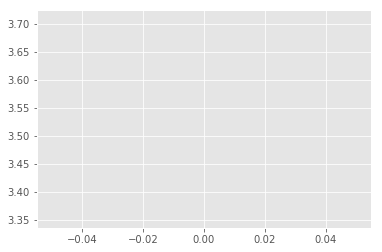

Epoch 1/1
4s - loss: 3.4500 - acc: 0.4287


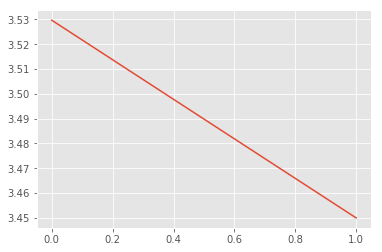

-- Epoch: 0 Test data ---
Encoder input:          today out stuff her moved carol
Decoder input: <BOS> ohh <EOS>            
Generated output: <BOS> oh <EOS>
-- Epoch: 0 Train data ---
Encoder input:   some them bring should we think you do amazing is stuffing this umm
Decoder input: <BOS> when they are hungry enough they will come in <EOS>    
Generated output: <BOS> oh <EOS>
==== Saving weights (localdata/friends_weights.h5) ====
Epoch 1/1
4s - loss: 3.4783 - acc: 0.4163


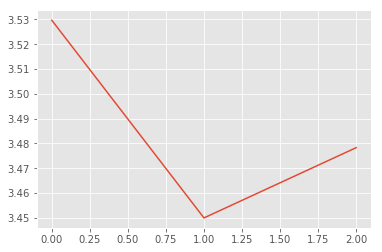

Epoch 1/1
3s - loss: 3.4227 - acc: 0.4288


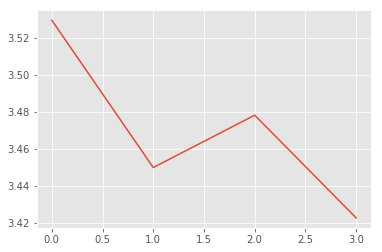

-- Epoch: 1 Test data ---
Encoder input:     me left she her with hell to not did i no
Decoder input: <BOS> and you never knew she was a lesbian <EOS>     
Generated output: <BOS> i <EOS>
-- Epoch: 1 Train data ---
Encoder input: to afford can i ok either roommate a need not did i woah woah woah
Decoder input: <BOS> what are you gettin so <UNK> out of <UNK> for huh it is <EOS>
Generated output: <BOS> i <EOS>
==== Saving weights (localdata/friends_weights.h5) ====
Epoch 1/1
3s - loss: 3.4255 - acc: 0.4271


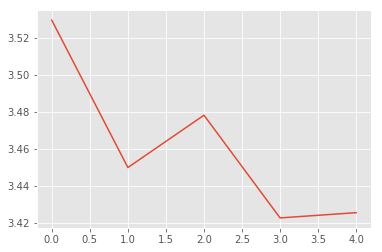

Epoch 1/1
4s - loss: 3.4623 - acc: 0.4184


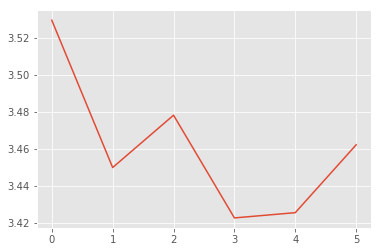

-- Epoch: 2 Test data ---
Encoder input:          today out stuff her moved carol
Decoder input: <BOS> ohh <EOS>            
Generated output: <BOS> yeah <EOS>
-- Epoch: 2 Train data ---
Encoder input:    this about know hospital the at people the do god my oh
Decoder input: <BOS> somebody wanna help me out here <EOS>       
Generated output: <BOS> yeah <EOS>
==== Saving weights (localdata/friends_weights.h5) ====
Epoch 1/1
4s - loss: 3.4249 - acc: 0.4246


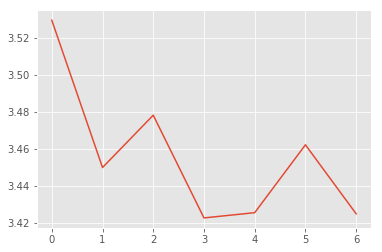

Epoch 1/1
4s - loss: 3.4517 - acc: 0.4199


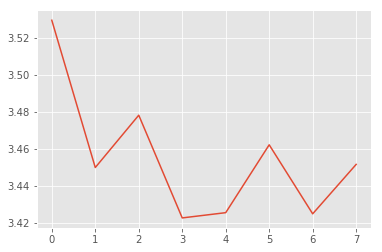

-- Epoch: 3 Test data ---
Encoder input:               hi
Decoder input: <BOS> this guy says hello i wanna kill myself <EOS>     
Generated output: <BOS> hey <EOS>
-- Epoch: 3 Train data ---
Encoder input:    pause long say to supposed not are you sorry sorry am i
Decoder input: <BOS> oh oh i thought that was your character is name you know i <EOS>
Generated output: <BOS> yeah <EOS>
==== Saving weights (localdata/friends_weights.h5) ====
Epoch 1/1
3s - loss: 3.4173 - acc: 0.4245


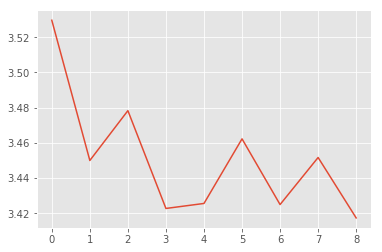

Epoch 1/1
3s - loss: 3.4523 - acc: 0.4209


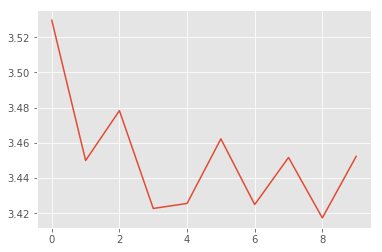

-- Epoch: 4 Test data ---
Encoder input:        pants those wearing be not should she ooh
Decoder input: <BOS> i say push her down the <UNK> <EOS>      
Generated output: <BOS> i <EOS>
-- Epoch: 4 Train data ---
Encoder input:         married is she believe not can i
Decoder input: <BOS> aw man i am sorry this must be very tough for ya huh <EOS>
Generated output: <BOS> i i
==== Saving weights (localdata/friends_weights.h5) ====
Epoch 1/1
3s - loss: 3.4194 - acc: 0.4221


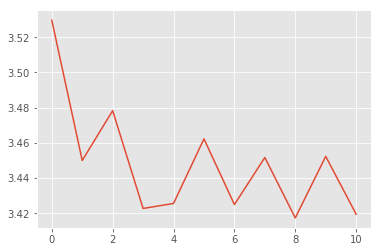

Epoch 1/1
3s - loss: 3.4315 - acc: 0.4237


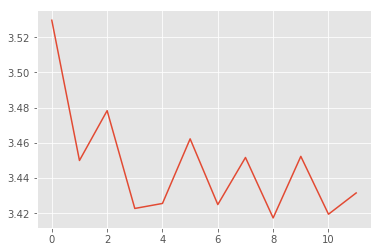

-- Epoch: 5 Test data ---
Encoder input:               sorry
Decoder input: <BOS> alright ross look you are feeling a lot of pain right now you <EOS>
Generated output: <BOS> oh <EOS>
-- Epoch: 5 Train data ---
Encoder input:            ten is here alright
Decoder input: <BOS> here i got five i got five <EOS>      
Generated output: <BOS> oh <EOS>
==== Saving weights (localdata/friends_weights.h5) ====
Epoch 1/1
4s - loss: 3.4294 - acc: 0.4207


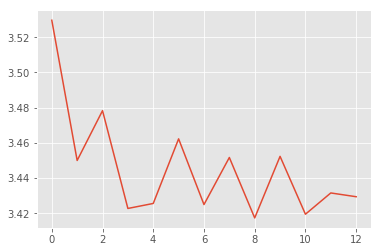

Epoch 1/1
4s - loss: 3.4018 - acc: 0.4252


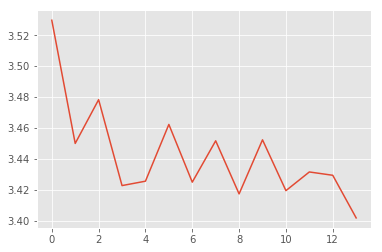

-- Epoch: 6 Test data ---
Encoder input: angry are you now right pain of lot a feeling are you look ross alright
Decoder input: <BOS> strip <UNK> come on you are single have some <UNK> <EOS>   
Generated output: <BOS> i <EOS>
-- Epoch: 6 Train data ---
Encoder input:     tribbiani <UNK> and joey please one next the have i can
Decoder input: <BOS> that is us <EOS>          
Generated output: <BOS> hey <EOS>
==== Saving weights (localdata/friends_weights.h5) ====
Epoch 1/1
4s - loss: 3.4165 - acc: 0.4258


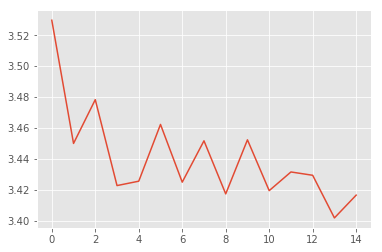

Epoch 1/1
4s - loss: 3.4230 - acc: 0.4203


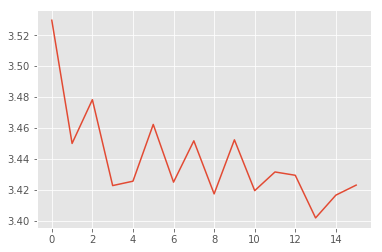

-- Epoch: 7 Test data ---
Encoder input:          today out stuff her moved carol
Decoder input: <BOS> ohh <EOS>            
Generated output: <BOS> yeah <EOS> <EOS>
-- Epoch: 7 Train data ---
Encoder input:        something do to have i remembered just i
Decoder input: <BOS> oh what <EOS>           
Generated output: <BOS> oh i <EOS>
==== Saving weights (localdata/friends_weights.h5) ====
Epoch 1/1
4s - loss: 3.3960 - acc: 0.4234


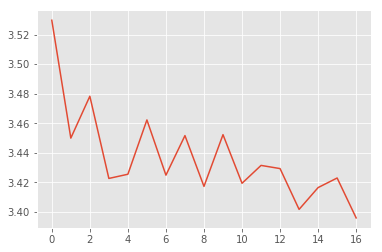

Epoch 1/1
4s - loss: 3.4224 - acc: 0.4221


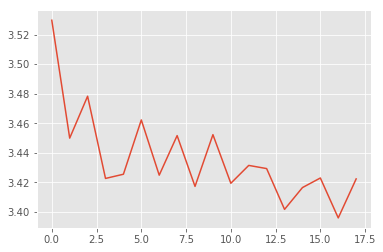

-- Epoch: 8 Test data ---
Encoder input:    there phone a is there realize i and down look i then
Decoder input: <BOS> instead of <EOS>           
Generated output: <BOS> yeah <EOS>
-- Epoch: 8 Train data ---
Encoder input:        here in richard keeping be monica would why
Decoder input: <BOS> well off the top of my head uhh maybe she is having her <EOS>
Generated output: <BOS> yeah <EOS>
==== Saving weights (localdata/friends_weights.h5) ====
Epoch 1/1
3s - loss: 3.4424 - acc: 0.4159


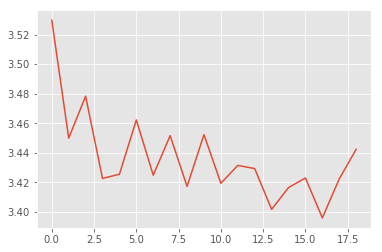

Epoch 1/1
4s - loss: 3.3612 - acc: 0.4294


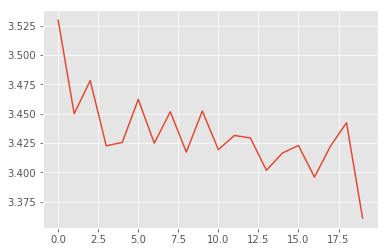

-- Epoch: 9 Test data ---
Encoder input:    there phone a is there realize i and down look i then
Decoder input: <BOS> instead of <EOS>           
Generated output: <BOS> i i
-- Epoch: 9 Train data ---
Encoder input:           her find go gotta i
Decoder input: <BOS> whoa hey whoa hold up are you serious so like 3 of the <EOS>
Generated output: <BOS> i i
==== Saving weights (localdata/friends_weights.h5) ====
Epoch 1/1
4s - loss: 3.3965 - acc: 0.4228


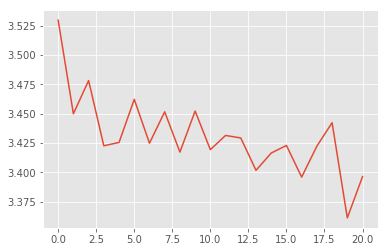

Epoch 1/1
3s - loss: 3.4084 - acc: 0.4233


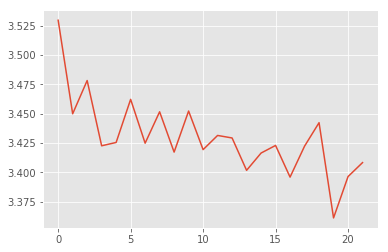

-- Epoch: 10 Test data ---
Encoder input:               hi
Decoder input: <BOS> this guy says hello i wanna kill myself <EOS>     
Generated output: <BOS> hey <EOS>
-- Epoch: 10 Train data ---
Encoder input: that said he anyway upstate nice so are people vet the to talked i ok
Decoder input: <BOS> good <EOS>            
Generated output: <BOS> i <EOS>
==== Saving weights (localdata/friends_weights.h5) ====
Epoch 1/1
3s - loss: 3.3827 - acc: 0.4225


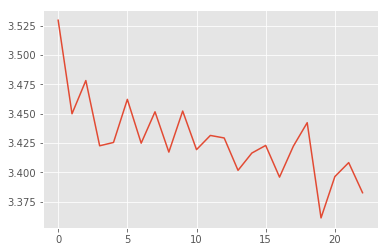

Epoch 1/1
3s - loss: 3.4030 - acc: 0.4236


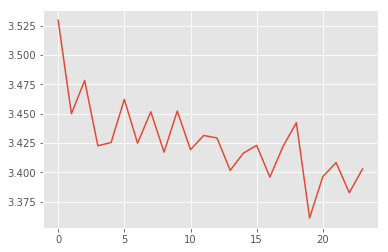

-- Epoch: 11 Test data ---
Encoder input:               hi
Decoder input: <BOS> this guy says hello i wanna kill myself <EOS>     
Generated output: <BOS> hey <EOS>
-- Epoch: 11 Train data ---
Encoder input: anything me buy not did you and here in go gonna am i look alright
Decoder input: <BOS> no no you can not you can not okay you can not you <EOS>
Generated output: <BOS> oh <EOS>
==== Saving weights (localdata/friends_weights.h5) ====
Epoch 1/1
3s - loss: 3.4253 - acc: 0.4177


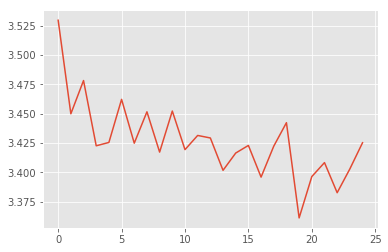

Epoch 1/1
3s - loss: 3.3578 - acc: 0.4281


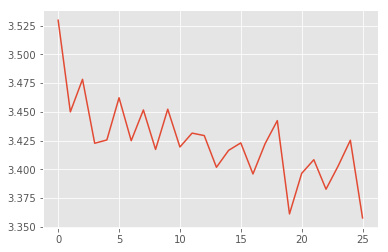

-- Epoch: 12 Test data ---
Encoder input:               hi
Decoder input: <BOS> this guy says hello i wanna kill myself <EOS>     
Generated output: <BOS> hey <EOS>
-- Epoch: 12 Train data ---
Encoder input:               hi
Decoder input: <BOS> hey you made it <EOS>         
Generated output: <BOS> hey <EOS>
==== Saving weights (localdata/friends_weights.h5) ====
Epoch 1/1
3s - loss: 3.4014 - acc: 0.4206


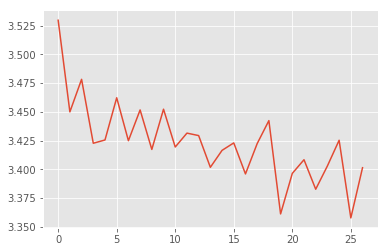

Epoch 1/1
3s - loss: 3.3835 - acc: 0.4252


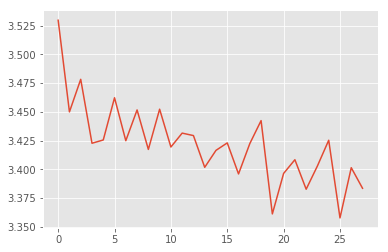

-- Epoch: 13 Test data ---
Encoder input:        pants those wearing be not should she ooh
Decoder input: <BOS> i say push her down the <UNK> <EOS>      
Generated output: <BOS> yeah <EOS>
-- Epoch: 13 Train data ---
Encoder input: was i thought he because me <UNK> just was chandler deal big no is it
Decoder input: <BOS> what how could you do that how could you think she was mary <EOS>
Generated output: <BOS> oh <EOS>
==== Saving weights (localdata/friends_weights.h5) ====
Epoch 1/1
3s - loss: 3.3641 - acc: 0.4257


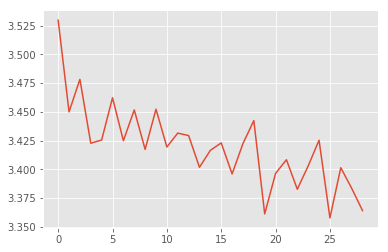

Epoch 1/1
4s - loss: 3.3927 - acc: 0.4207


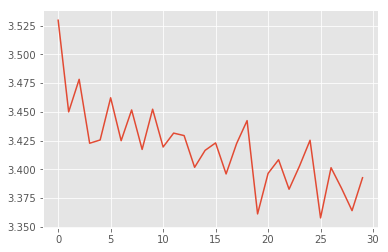

-- Epoch: 14 Test data ---
Encoder input:     me left she her with hell to not did i no
Decoder input: <BOS> and you never knew she was a lesbian <EOS>     
Generated output: <BOS> i <EOS>
-- Epoch: 14 Train data ---
Encoder input: bedroom that is it geller <UNK> monica alright name middle a have i do oh
Decoder input: <BOS> hey monica bought a bed from the <UNK> king <EOS>    
Generated output: <BOS> i <EOS>
==== Saving weights (localdata/friends_weights.h5) ====
Epoch 1/1
3s - loss: 3.3442 - acc: 0.4273


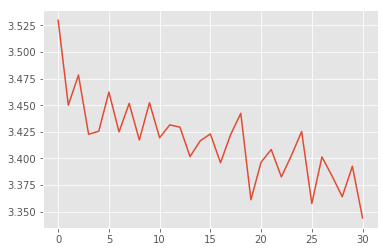

Epoch 1/1
4s - loss: 3.4141 - acc: 0.4194


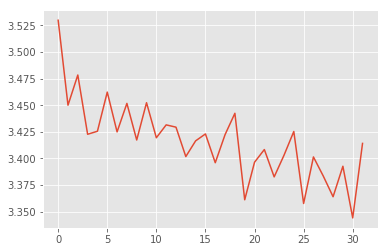

-- Epoch: 15 Test data ---
Encoder input:     me left she her with hell to not did i no
Decoder input: <BOS> and you never knew she was a lesbian <EOS>     
Generated output: <BOS> oh <EOS>
-- Epoch: 15 Train data ---
Encoder input:               hands
Decoder input: <BOS> hands it is absolutely <UNK> that you tell me what room the man <EOS>
Generated output: <BOS> yeah <EOS>
==== Saving weights (localdata/friends_weights.h5) ====
Epoch 1/1
3s - loss: 3.3558 - acc: 0.4264


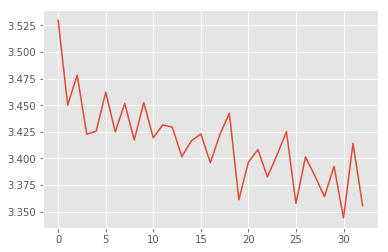

Epoch 1/1
3s - loss: 3.3821 - acc: 0.4197


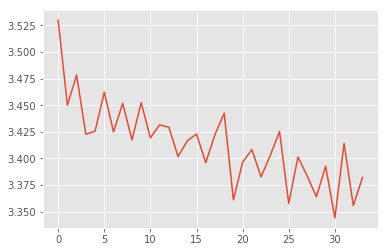

-- Epoch: 16 Test data ---
Encoder input:        pants those wearing be not should she ooh
Decoder input: <BOS> i say push her down the <UNK> <EOS>      
Generated output: <BOS> i <EOS>
-- Epoch: 16 Train data ---
Encoder input:     <UNK> last my is that that with time your take joey
Decoder input: <BOS> no more jam <EOS>          
Generated output: <BOS> i i
==== Saving weights (localdata/friends_weights.h5) ====
Epoch 1/1
3s - loss: 3.3592 - acc: 0.4232


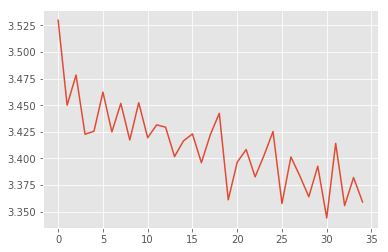

Epoch 1/1
4s - loss: 3.3729 - acc: 0.4227


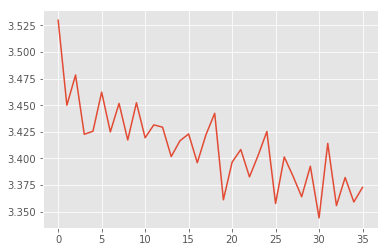

-- Epoch: 17 Test data ---
Encoder input:    there phone a is there realize i and down look i then
Decoder input: <BOS> instead of <EOS>           
Generated output: <BOS> oh <EOS>
-- Epoch: 17 Train data ---
Encoder input:           so think not did i
Decoder input: <BOS> uh if i may umm umm look cliff you told me a lot <EOS>
Generated output: <BOS> yeah <EOS>
==== Saving weights (localdata/friends_weights.h5) ====
Epoch 1/1
4s - loss: 3.3369 - acc: 0.4270


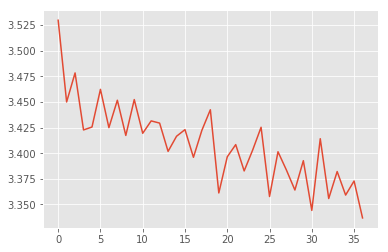

Epoch 1/1
3s - loss: 3.3932 - acc: 0.4188


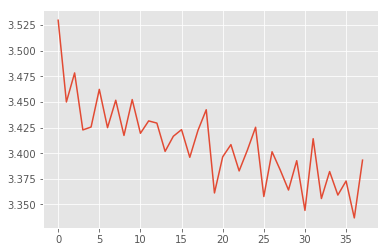

-- Epoch: 18 Test data ---
Encoder input:               sorry
Decoder input: <BOS> alright ross look you are feeling a lot of pain right now you <EOS>
Generated output: <BOS> hey <EOS>
-- Epoch: 18 Train data ---
Encoder input: use not did just means <UNK> word the what know not did you if look
Decoder input: <BOS> no look you know charlie right she is cool she is funny her <EOS>
Generated output: <BOS> oh i
==== Saving weights (localdata/friends_weights.h5) ====
Epoch 1/1
4s - loss: 3.3541 - acc: 0.4226


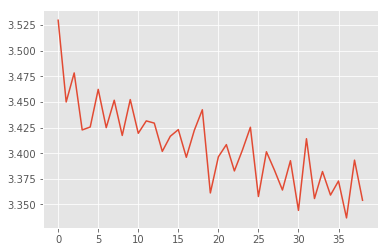

Epoch 1/1
4s - loss: 3.3536 - acc: 0.4231


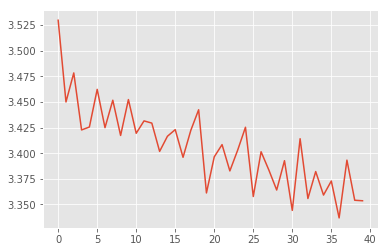

-- Epoch: 19 Test data ---
Encoder input:          today out stuff her moved carol
Decoder input: <BOS> ohh <EOS>            
Generated output: <BOS> i <EOS>
-- Epoch: 19 Train data ---
Encoder input:             guys you love
Decoder input: <BOS> you know i am really sorry i was not more supportive before <EOS> 
Generated output: <BOS> yeah <EOS>
==== Saving weights (localdata/friends_weights.h5) ====
Epoch 1/1
4s - loss: 3.3021 - acc: 0.4296


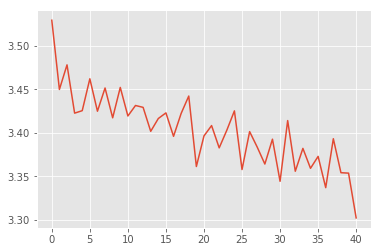

Epoch 1/1
4s - loss: 3.3942 - acc: 0.4167


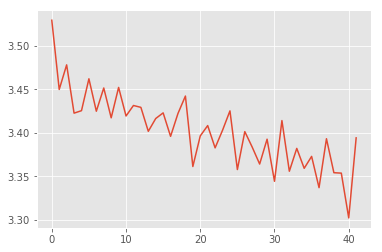

-- Epoch: 20 Test data ---
Encoder input:     me left she her with hell to not did i no
Decoder input: <BOS> and you never knew she was a lesbian <EOS>     
Generated output: <BOS> hey <EOS>
-- Epoch: 20 Train data ---
Encoder input:          <UNK> am i <UNK> am i
Decoder input: <BOS> yeah she is been out there for twenty minutes i am surprised you <EOS>
Generated output: <BOS> oh <EOS>
==== Saving weights (localdata/friends_weights.h5) ====
Epoch 1/1
4s - loss: 3.3303 - acc: 0.4253


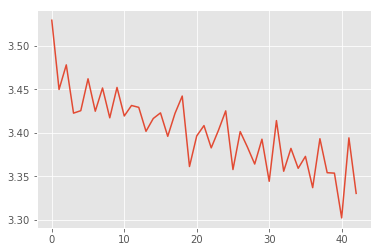

Epoch 1/1
4s - loss: 3.3629 - acc: 0.4217


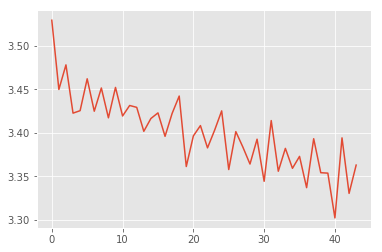

-- Epoch: 21 Test data ---
Encoder input:        pants those wearing be not should she ooh
Decoder input: <BOS> i say push her down the <UNK> <EOS>      
Generated output: <BOS> yeah <EOS>
-- Epoch: 21 Train data ---
Encoder input: asking about something <UNK> he city the in night first my mean i none no
Decoder input: <BOS> well given that he is <UNK> in love with you he probably would <EOS>
Generated output: <BOS> oh <EOS>
==== Saving weights (localdata/friends_weights.h5) ====
Epoch 1/1
4s - loss: 3.3015 - acc: 0.4295


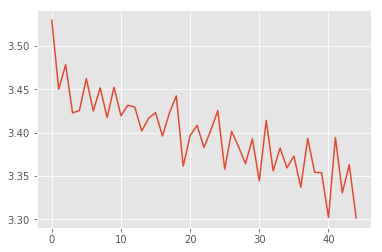

Epoch 1/1
4s - loss: 3.3803 - acc: 0.4177


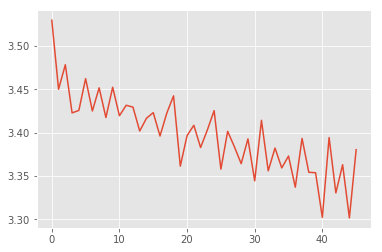

-- Epoch: 22 Test data ---
Encoder input:    there phone a is there realize i and down look i then
Decoder input: <BOS> instead of <EOS>           
Generated output: <BOS> oh <EOS>
-- Epoch: 22 Train data ---
Encoder input:            talking you are what
Decoder input: <BOS> hey did not look at me i just work here <EOS>   
Generated output: <BOS> i <EOS>
==== Saving weights (localdata/friends_weights.h5) ====
Epoch 1/1
4s - loss: 3.3548 - acc: 0.4172


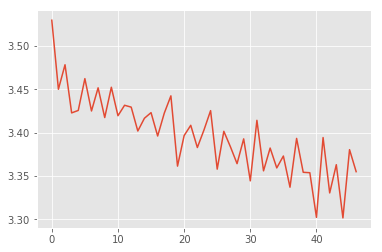

Epoch 1/1
4s - loss: 3.3047 - acc: 0.4299


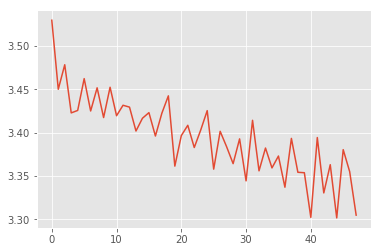

-- Epoch: 23 Test data ---
Encoder input:     me left she her with hell to not did i no
Decoder input: <BOS> and you never knew she was a lesbian <EOS>     
Generated output: <BOS> oh <EOS>
-- Epoch: 23 Train data ---
Encoder input: after this deserve you know y is it is it terrific is it no oh
Decoder input: <BOS> okay okay fine make jokes i did not care this is a big <EOS>
Generated output: <BOS> oh <EOS>
==== Saving weights (localdata/friends_weights.h5) ====
Epoch 1/1
4s - loss: 3.3217 - acc: 0.4246


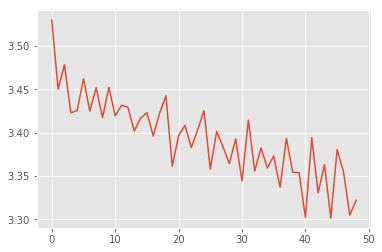

Epoch 1/1
4s - loss: 3.3323 - acc: 0.4229


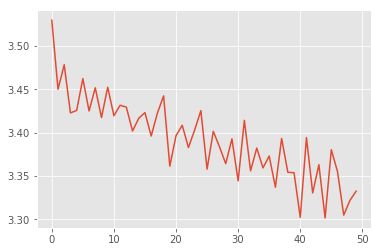

-- Epoch: 24 Test data ---
Encoder input:               hi
Decoder input: <BOS> this guy says hello i wanna kill myself <EOS>     
Generated output: <BOS> hey <EOS>
-- Epoch: 24 Train data ---
Encoder input: to you over all were they when you are you him not are you hey
Decoder input: <BOS> no <EOS>            
Generated output: <BOS> oh <EOS>
==== Saving weights (localdata/friends_weights.h5) ====
Epoch 1/1
4s - loss: 3.3312 - acc: 0.4197


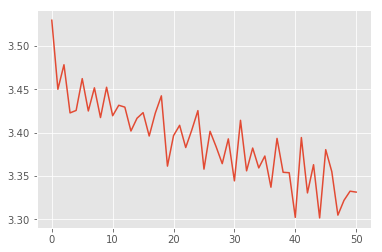

Epoch 1/1


KeyboardInterrupt: 

In [32]:
train()

# Testing (Inference i.e. time to chat)

To perform inference, we first pass the pre-processed inputs into the predict function of our model. This will return a sequence of probabilities of each word in our vocabulary. We select the one with the highest probability and find its associated word using our vocabulary. 

<img src='images/inference.png' width='30%' />

In [40]:
import re

from IPython.display import display 
from ipywidgets import widgets

In [34]:
def preprocess_text(word_2_index, text):
    """
    takes input from the user and prepares it for our machine learning model 
    """
    # normalise case 
    text = text.lower()             
    
    # substitute words 
    replacements = [
        ("wan't", "want"), 
        ("didn't", "did not"), 
        ("don't", "did not"),  
        ("won't", "will not"),
        ("can't", "can not"), 
        ("we'd", "we would"), 
        ("i'd", "i would"),    
        ("n't", " not"), 
        ("’ve", " have"), 
        ("'ll", " will"), 
        ("'m", " am"), 
        ("'t", " not"), 
        ("'re", " are"), 
        ("'s", " is"), 
        ("'d", " would")
    ]
    
    for k, v in replacements:
        text = text.replace(k, v)
        
            
    # remove punctuation characters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text) 
    
    # tokenise 
    words = text.split()    
    
    # reverse string 
    words = words[::-1]
    
    # replaced words not in our vocab with the UNK token 
    words = [w if w in word_2_index else constants.TAG_UNK for w in words]
    
    # substitute words with their indices 
    words = [word_2_index[w] for w in words]
    
    # convert to numpy array 
    words = np.asanyarray(words)
    
    # pad 
    seq = sequence.pad_sequences([words], maxlen=constants.MAX_INPUT_LENGTH)
    
    return seq

In [35]:
def predict(model, word_2_index, index_2_word, ecoder_input):
    """
    taking the current state of the model and making a prediction on the
    ecoder_input. 
    """
        
    prediction = np.argmax(model.predict(ecoder_input), axis=2)[0]
    predicted_output = ' '.join([index_2_word[index] for index in prediction 
                                 if index in index_2_word and index > 0])
    
    # just return up to the first EOS 
    if constants.TAG_EOS in predicted_output:
        eos_index = predicted_output.split().index(constants.TAG_EOS)
        predicted_output = " ".join([word for idx, word in enumerate(predicted_output.split()) if idx < eos_index])
    # remove metadata 
    predicted_output = predicted_output.replace(constants.TAG_BOS, "").replace(constants.TAG_EOS, "")    
    predicted_output = predicted_output.replace(constants.TAG_PAD, "") 
    predicted_output = predicted_output.replace(constants.TAG_UNK, "???")
    
    # remove leading and trialing spaces
    predicted_output = predicted_output.strip()
    
    return predicted_output

In [36]:
def test():
    MAIN_ACTOR = "Computer"
    
    # load vocab and word2index dict
    index_2_word, word_2_index = load_vocab() 
    print("loaded vocab - vocab size {}".format(len(word_2_index)))
    
    # load/create embedding matrix 
    embedding_matrix = load_embedding_matrix(index_2_word)
    print("loaded embedding matrix {}".format(embedding_matrix.shape))
    
    # load model 
    model = create_model(embedding_matrix)
    print("created model")
    
    # UI to handle accepting text from the user and displaying the predicted response from the model 
    def on_submit_text_user(sender):
        """
        callback when the user hits enter in their text field 
        """
        
        nonlocal index_2_word, word_2_index, model
        
        query = text_user.value 
        
        # process text 
        status_text = "User: {}".format(query)
        query_seq = preprocess_text(word_2_index, query) 
        
        # predict response 
        response = predict(model, word_2_index, index_2_word, query_seq)
        
        status_text = "{} => Comp: {}".format(status_text, response)
        print(status_text)
        
        # display response 
        text_computer.value = "{}".format(response)  
        
        # clear out users input
        text_user.value = ""
        
        
    text_user = widgets.Text(description="You: ", width=200)     
    text_user.on_submit(on_submit_text_user)
    
    text_computer = widgets.Text(description="{}: ".format(MAIN_ACTOR), width=200)     
    
    cb_container = widgets.HBox()
    cb_container.children=[text_user, text_computer]
    display(cb_container)

In [41]:
test()

loaded vocab - vocab size 2193
loading previously created embedding matrix workingdata/friends_embedding_matrix.npy
loaded embedding matrix (2193, 100)
Loading weights from file localdata/friends_weights.h5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_embedding (Embedding (None, 15, 100)           219300    
_________________________________________________________________
encoder_lstm (LSTM)          (None, 300)               481200    
_________________________________________________________________
encoder_repeat_vector (Repea (None, 15, 300)           0         
_________________________________________________________________
decoder_lstm_0 (LSTM)        (None, 15, 300)           721200    
_________________________________________________________________
decoder_lstm_0_dropout (Drop (None, 15, 300)           0         
_________________________________________________________________
d